In [ ]:
!nvidia-smi

Fri Dec 17 16:55:28 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P0    61W / 149W |    207MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Now that we have used pretrained model for prediction (especially feature extraction) let's now see the fine tuning technique

> As one can understand Fine tuning means - tuning a pretrained model to suit our requirement.
> we set `trainabel` parameter of some of the layers of the pretrained model to `True` there by makeing them train on our set of data.
> we generally lower the learning rate by 10X. However there are different opinions on this matter. we can mannupulate the larning rate as per our rquirement

In [ ]:
# Get helper_functions.py script from course GitHub
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py 

# Import helper functions we're going to use
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

--2021-12-17 16:55:29--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-12-17 16:55:29 (71.8 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [ ]:
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip 

unzip_data("10_food_classes_10_percent.zip")

In [ ]:
walk_through_dir('10_food_classes_10_percent')

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/tes

**Note that we have only taken 10% (75 out of 750 images) of the training data without changing the test data (all 250 images are intact).** 

In [ ]:
# create directory paths [train directory and test directory]
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

# tf.kears.preprocessing.image_dataset_from_directory() function
# let's preprocess and prepare the dataset for training
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

image_size = (224,224)

train_data_10_percent = image_dataset_from_directory(directory = train_dir,
                                                     image_size = image_size,
                                                     label_mode = 'categorical',
                                                     batch_size = 32)

test_data = image_dataset_from_directory(directory = test_dir,
                                                    image_size = image_size,
                                                    label_mode = 'categorical',
                                                    batch_size = 32)


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


> **NOTE:** we are not using `ImageDataGenerator` and `flow_from_directory` to create our dataset. we are instead using the one step process `image_dataset_from_directory` method from keras preprocessing.

> Also note that even though we name our test data set as `test_data_10_percent` the test data has not changed from the begining.


In [ ]:
# the processed data set has attributes such as class name see the documentation https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [ ]:
# see an example batch data
for images, labels in train_data_10_percent.take(1):
  print(f'Image Tensors \n {images}')
  print(f'Label Tensor \n {labels}')

Image Tensors 
 [[[[3.01581631e+01 1.51581640e+01 8.15816402e+00]
   [3.19540825e+01 1.69540825e+01 1.19540815e+01]
   [3.09285717e+01 1.59285717e+01 1.13571434e+01]
   ...
   [1.66500290e+02 9.40054016e+01 5.53474121e+01]
   [1.18321342e+02 5.25356674e+01 1.80355759e+01]
   [1.12566734e+02 5.29239159e+01 1.83691418e+00]]

  [[2.90255108e+01 1.60255108e+01 8.02550983e+00]
   [3.30714264e+01 1.80714283e+01 1.10714283e+01]
   [3.03571434e+01 1.53571424e+01 1.03571424e+01]
   ...
   [1.61994659e+02 8.99946671e+01 4.82805519e+01]
   [1.14142899e+02 4.92857933e+01 1.12704439e+01]
   [1.38225037e+02 7.82250290e+01 2.67963219e+01]]

  [[3.15765305e+01 1.87908173e+01 9.14795876e+00]
   [3.20867348e+01 1.90867348e+01 1.00867348e+01]
   [2.90918369e+01 1.44744902e+01 7.04591846e+00]
   ...
   [1.36902222e+02 6.83819122e+01 2.18054790e+01]
   [1.19285767e+02 5.69694862e+01 1.36990690e+01]
   [1.42045319e+02 8.40606537e+01 3.76983299e+01]]

  ...

  [[1.07668503e+02 7.76685028e+01 4.00970306e+01]


In [ ]:
for images, labels in train_data_10_percent:
  print(labels)

tf.Tensor(
[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

In [ ]:
len(train_data_10_percent.take(5))

5

In [ ]:
list(train_data_10_percent.take(5))

[(<tf.Tensor: shape=(32, 224, 224, 3), dtype=float32, numpy=
  array([[[[1.16357147e+02, 1.43642853e+02, 1.66000000e+02],
           [1.11454079e+02, 1.35545914e+02, 1.59500000e+02],
           [1.11780609e+02, 1.31857132e+02, 1.56132645e+02],
           ...,
           [1.14367241e+02, 1.47367249e+02, 1.66367249e+02],
           [1.07142830e+02, 1.40142838e+02, 1.59142838e+02],
           [1.02056068e+02, 1.35056061e+02, 1.54056061e+02]],
  
          [[1.13285713e+02, 1.38071426e+02, 1.60142868e+02],
           [1.10071426e+02, 1.32000000e+02, 1.54857132e+02],
           [1.09984695e+02, 1.27913269e+02, 1.49311218e+02],
           ...,
           [1.15555946e+02, 1.48413086e+02, 1.67484528e+02],
           [1.03790794e+02, 1.36647934e+02, 1.55719360e+02],
           [1.01668335e+02, 1.34525482e+02, 1.53596909e+02]],
  
          [[1.11571426e+02, 1.32785721e+02, 1.54214294e+02],
           [1.09928566e+02, 1.28571426e+02, 1.48785706e+02],
           [1.09785713e+02, 1.26000000e+02, 1

# Model 0 Building a transfer learning model using keras functional API

To do this we are going to be using [tf.keras.applications](https://www.tensorflow.org/api_docs/python/tf/keras/applications) module as it contains a series of already trained (on ImageNet) computer vison models as well as keras functional API to construct our model

### Steps in building the model

1. instantiate the pretrained model object by choosing a target model such as [EfficientNetB0](https://www.tensorflow.org/api_docs/python/tf/keras/applications/EfficientNetB0) from `tf.keras.applications`, 

2. set the base model `trainable` attribute to `False` to freaze all of the weights in the trained model.
3. Define an input layer for our model
4. Normalize you data - this is optional - as some of the models have inbuilt normalization layer.
5. pass the inputs to the base model
6. Pool the outputs of the base model into a shape, compatiable with the output Dense layer (turn base model out tensors into same shape as label tensors). This can be done using [tf.keras.layers.GlobalAveragePooling2D()](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D) or [tf.keras.layers.GlobalMaxPooling2D()](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalMaxPool2D?hl=en) though the former is more common practice. choose one that works for you.
7. Create output Activation layer using `tf.keras.layers.Dense()` with appropriate activation function and appropriate no of neurons for classification.
8. combine the input and output layers into a model using [tf.keras.Model()](https://www.tensorflow.org/api_docs/python/tf/keras/Model)
9. Compile the model using appropriate loss function and choos the appropriate optimizer and learning rate.
10. fit the model for desired number of epocs with necessary callbacks. 

In [ ]:
# create a base model with tf.keras.applications
import tensorflow as tf
base_model = tf.keras.applications.EfficientNetB0(include_top=False, 
                                                 weights='imagenet', 
                                                 input_tensor=None,
                                                 input_shape=None, 
                                                 pooling=None, 
                                                 classes=1000, # since include_top is false this parameter is useless
                                                 classifier_activation='softmax')

# Freeze the base model
base_model.trainable =  False

# Create Input layer for our base model
inputs = tf.keras.layers.Input(shape = (224,224,3), name = 'Input layer')

# Normalization layer Add only if required (efficeintnet has its own normaisation layer)
# x = tf.keras.layers.experimental.preprocessing.Rescaling(7/255.)

# pass the inputs to our base model (note that only if you using keras.application the input data for efficientnet need not be normalized)
x = base_model(inputs)
# Check the data shape after passing inputs to the base model
print(f'Shape after base model : {x.shape}')

# Average pool the ouputs of the base model
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# Create an optput / classification layer
outputs = tf.keras.layers.Dense(10, activation = 'softmax')(x)

# Combine the inputs and outputs into a model using tf.keras.Model
model_0 = tf.keras.Model(inputs,outputs, name = 'baseline_model')

# Compile the model
model_0.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

# fit the model
history_10_percent_baseline = model_0.fit(train_data_10_percent,
                                          epochs = 5,
                                          steps_per_epoch = len(train_data_10_percent),
                                          validation_data = test_data,
                                          validation_steps = int(0.25 * len(test_data)),
                                          callbacks = [create_tensorboard_callback('transfer_learning',
                                                                           '10_percent_feature_extract_baseline')])

Shape after base model : (None, 7, 7, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extract_baseline/20211217-165539


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/5
24/24 [==============================] - 18s 354ms/step - loss: 1.8385 - accuracy: 0.4707 - val_loss: 1.3165 - val_accuracy: 0.7056
Epoch 2/5
24/24 [==============================] - 7s 265ms/step - loss: 1.1109 - accuracy: 0.7613 - val_loss: 0.9137 - val_accuracy: 0.7829
Epoch 3/5
24/24 [==============================] - 9s 371ms/step - loss: 0.8117 - accuracy: 0.8187 - val_loss: 0.7695 - val_accuracy: 0.8076
Epoch 4/5
24/24 [==============================] - 9s 364ms/step - loss: 0.6696 - accuracy: 0.8533 - val_loss: 0.6925 - val_accuracy: 0.8125
Epoch 5/5
24/24 [==============================] - 8s 292ms/step - loss: 0.5846 - accuracy: 0.8773 - val_loss: 0.6285 - val_accuracy: 0.8240


In [ ]:
# del model_0

In [ ]:
for layer_number, layer in enumerate(base_model.layers):
  print(f'{layer_number:>4}:{layer.name}')

   0:input_3
   1:rescaling_2
   2:normalization_2
   3:stem_conv_pad
   4:stem_conv
   5:stem_bn
   6:stem_activation
   7:block1a_dwconv
   8:block1a_bn
   9:block1a_activation
  10:block1a_se_squeeze
  11:block1a_se_reshape
  12:block1a_se_reduce
  13:block1a_se_expand
  14:block1a_se_excite
  15:block1a_project_conv
  16:block1a_project_bn
  17:block2a_expand_conv
  18:block2a_expand_bn
  19:block2a_expand_activation
  20:block2a_dwconv_pad
  21:block2a_dwconv
  22:block2a_bn
  23:block2a_activation
  24:block2a_se_squeeze
  25:block2a_se_reshape
  26:block2a_se_reduce
  27:block2a_se_expand
  28:block2a_se_excite
  29:block2a_project_conv
  30:block2a_project_bn
  31:block2b_expand_conv
  32:block2b_expand_bn
  33:block2b_expand_activation
  34:block2b_dwconv
  35:block2b_bn
  36:block2b_activation
  37:block2b_se_squeeze
  38:block2b_se_reshape
  39:block2b_se_reduce
  40:block2b_se_expand
  41:block2b_se_excite
  42:block2b_project_conv
  43:block2b_project_bn
  44:block2b_drop


In [ ]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_2 (Rescaling)        (None, None, None,   0           ['input_3[0][0]']                
                                3)                                                                
                                                                                                  
 normalization_2 (Normalization  (None, None, None,   7          ['rescaling_2[0][0]']            
 )                              3)                                                   

In [ ]:
model_0.summary()

Model: "baseline_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


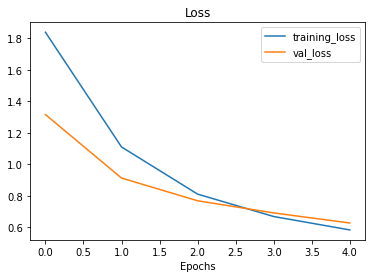

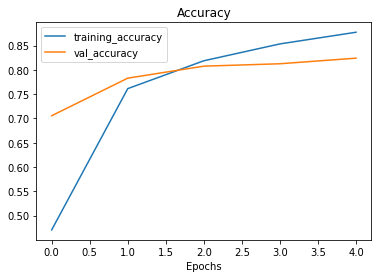

In [ ]:
plot_loss_curves(history_10_percent_baseline)

In [ ]:
# Define input tensor shape 
input_shape = (1,4,2,3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.uniform(input_shape)
print(f'Random input Tensor: \n{input_tensor}\n')

Random input Tensor: 
[[[[0.6645621  0.44100678 0.3528825 ]
   [0.46448255 0.03366041 0.68467236]]

  [[0.74011743 0.8724445  0.22632635]
   [0.22319686 0.3103881  0.7223358 ]]

  [[0.13318717 0.5480639  0.5746088 ]
   [0.8996835  0.00946367 0.5212307 ]]

  [[0.6345445  0.1993283  0.72942245]
   [0.54583454 0.10756552 0.6767061 ]]]]



In [ ]:
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f'2D Average pooled random tensor : \n {global_average_pooled_tensor}\n')

2D Average pooled random tensor : 
 [[0.5382011  0.31524014 0.5610231 ]]



In [ ]:
print(f'Shape of input tensor: {input_tensor.shape}')
print(f'Sahpe of 2D Global Average pooled Tensor: {global_average_pooled_tensor.shape}')

Shape of input tensor: (1, 4, 2, 3)
Sahpe of 2D Global Average pooled Tensor: (1, 3)


In [ ]:
tf.reduce_mean(input_tensor, axis = [1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.5382011 , 0.31524014, 0.5610231 ]], dtype=float32)>

# Running a series of transfer learing experiments

> we have seen the power of transferlearing on 10% data. Transfer learnig does not need huge data. we can get good results on small dataset. let's try on 1% data to check

## List of experiments
1. `model_1`: Use feature extraction transfer learning on **1% training data** `with augmentation`
2. `model_2`: Use feature extraction transfer learning on **10% data**  with `Data Augmentation`
3. `model_3`: Use fine-tuning transfer learning on **10% of data** with `Data Augmentation`
4. `model_4`: Use fine-tuning transfer learning on **100% data** with `Data Augmentation`

> while all the experiments will be run on different version of training data, they will be evaluated on the same test data. This will ensure all the results are comparabel

**All experiments will be done using `EfficientNetB0` model using `tf.keras.applications` module.

so let's begin

In [ ]:
# Dowloan and unzip data for First model - **1% training data**
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data('10_food_classes_1_percent.zip')

# Create train and test directories (paths)
train_dir_1_percent = '10_food_classes_1_percent/train/'
test_dir = '10_food_classes_1_percent/test'

--2021-12-17 16:56:42--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.125.128, 142.250.152.128, 142.250.136.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.125.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   174MB/s    in 0.7s    

2021-12-17 16:56:43 (174 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [ ]:
walk_through_dir('10_food_classes_1_percent')

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'

In [ ]:
train_data_1_percent = image_dataset_from_directory(train_dir_1_percent,
                                                    image_size = (224,224),
                                                    label_mode = 'categorical',
                                                    batch_size = 32)

test_data = image_dataset_from_directory(test_dir,
                                         image_size = (224,224),
                                         label_mode = 'categorical')

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


# Adding Data Augmentation right into the model

Previously we used ImageDataGenerator to augment the data. However, now we can use [tf.keras.layers] to incorporate augmentation as a layer in the model.


In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

In [ ]:
# create Data augmentation layer
data_augmentation = keras.Sequential([
                                      layers.RandomFlip('horizontal'),
                                      layers.RandomZoom(0.2,),
                                      layers.RandomRotation(0.2),
                                      layers.RandomHeight(0.2),
                                      layers.RandomZoom(0.2)
], name = 'augmentation_layer')


Text(0.5, 1.0, 'Augmented random image from class: chicken_curry')

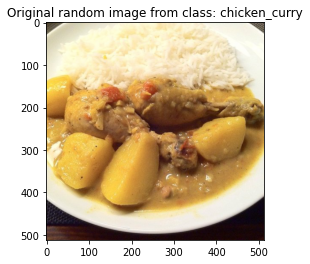

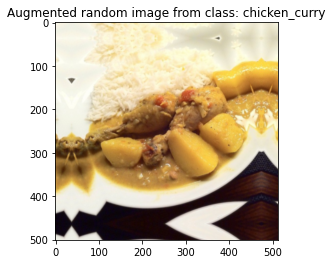

In [ ]:
# Let's try to visualize the augmented images
import matplotlib.pyplot as plt
import matplotlib.image as mpimage
import os
import random

# Show original image
target_class = random.choice(train_data_1_percent.class_names) # Choose a random class
target_dir = train_dir + target_class # Create a target directory path
random_image = random.choice(os.listdir(target_dir)) # choose a random image from the directory
random_image_path = target_dir + '/' + random_image # Create a random image path to be read from
image = mpimage.imread(random_image_path) # read the random image from path
plt.imshow(image) # show the image
plt.title(f'Original random image from class: {target_class}')

# Augment the image
augmented_image = data_augmentation(tf.expand_dims(image, axis = 0))
plt.figure()
plt.imshow(tf.squeeze(augmented_image)/255.)
plt.title(f'Augmented random image from class: {target_class}')


# Model 1 - Feature extraction transfer learning on 1% of the data with augmentation

In [ ]:
# setup input shape and base model. Also we will freeze all the layers
input_shape = (224,224,3)
base_model = keras.applications.EfficientNetB0(include_top = False)
base_model.trainalbe = False

# create input layer
inputs = layers.Input(shape = input_shape, name = 'Input_layer')

# Add data augmentation layer
x = data_augmentation(inputs)

# Give base model our augmented inputs and don't train the model parms 
x = base_model(x, training = False)

# Pool the outputs of the base model
x = layers.GlobalAveragePooling2D(name = 'Global_Average_Pooling_layer')(x)

# Put Dense layer on as the output
outputs = layers.Dense(10, activation = 'softmax', name = 'output_layer')(x)

# Put together inputs and outputs into a model
model_1 = keras.Model(inputs, outputs)

# compile the model
model_1.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

# fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs = 5,
                                steps_per_epoch = len(train_data_1_percent),
                                validation_data = test_data,
                                validation_steps = int(0.25 * len(test_data)),
                                callbacks = [create_tensorboard_callback('transfer_learning','1_percent_augmentation')])

Saving TensorBoard log files to: transfer_learning/1_percent_augmentation/20211217-170055


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/5
3/3 [==============================] - 31s 5s/step - loss: 2.4184 - accuracy: 0.0571 - val_loss: 2.4689 - val_accuracy: 0.1003
Epoch 2/5
3/3 [==============================] - 11s 4s/step - loss: 2.3915 - accuracy: 0.1143 - val_loss: 5.1848 - val_accuracy: 0.1086
Epoch 3/5
3/3 [==============================] - 9s 4s/step - loss: 3.8203 - accuracy: 0.0857 - val_loss: 2.3459 - val_accuracy: 0.1069
Epoch 4/5
3/3 [==============================] - 7s 2s/step - loss: 2.5313 - accuracy: 0.1571 - val_loss: 2.3678 - val_accuracy: 0.1201
Epoch 5/5
3/3 [==============================] - 8s 4s/step - loss: 2.3787 - accuracy: 0.0571 - val_loss: 2.3102 - val_accuracy: 0.1069


In [ ]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 augmentation_layer (Sequent  (None, None, None, 3)    0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 Global_Average_Pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 4,020,358
Non-tra

In [ ]:
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 13s 153ms/step - loss: 2.3098 - accuracy: 0.1028


[2.3097989559173584, 0.10279999673366547]

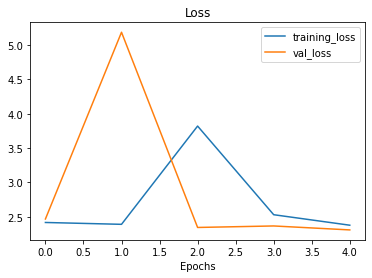

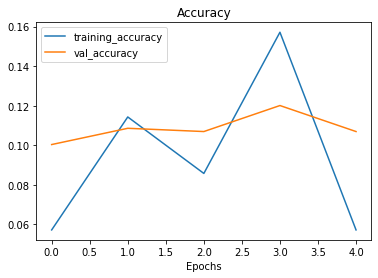

In [ ]:
plot_loss_curves(history_1_percent)

# Model 2: Feature extraction transfer learning with 10% data with data augmentation

In [ ]:
# create Directory path for data preprocessing
train_dir_10_percent = train_dir
test_dir = test_dir

# set up image shape
image_size = (224,224)

# Create train dataset on 10 percent data
train_data_10_percent = image_dataset_from_directory(train_dir_10_percent,
                                                     image_size = image_size,
                                                     label_mode = 'categorical',
                                                     batch_size = 32)

# Our Test data remains the same hence we dont create the dataset again. we will use the same test_data

Found 750 files belonging to 10 classes.


In [ ]:
# create functional model with data augmentation layer
from tensorflow.keras.models import Sequential

# Build data augmentation layer
data_augmentation = Sequential([
                                layers.RandomFlip('horizontal'),
                                layers.RandomRotation(0.2),
                                layers.RandomZoom(0.2),
                                layers.RandomHeight(0.2),
                                layers.RandomWidth(0.2),
                                # layers.RandomCrop()
], name = 'augmentation_layer')

# setup input shape to out model
input_shape = (224,224,3)

# Create a frozen base model
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

# Create input and output layer
inputs = layers.Input(shape = input_shape, name = 'input_layer')
x = data_augmentation(inputs)
x = base_model(x, training = False)
x = layers.GlobalAveragePooling2D(name = 'Global_average_pooling')(x)
outputs = layers.Dense(10, activation = 'softmax', name = 'output_layer')(x)
model_2 = keras.Model(inputs, outputs)

# compile model
model_2.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])


# Creating a model checkpoin callback


In [ ]:
# setup a checkpoint path
checkpoint_path = 'ten_percent_checkpoint_weights/checkpoint.ckpt'

# create a ModelCheckpoint callback that saves model weights only
checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath = checkpoint_path,
                                                      save_weights_only = True, # set to false to save the entire model
                                                      save_best_only = True, # Set to true to save only the best model instea of every epoch
                                                      save_freq = 'epoch',
                                                      verbose = 1)


In [ ]:
# Fit the 10 percent feature extraction model
initial_epoch = 5
history_10percent_mod_2 = model_2.fit(train_data_10_percent,
                                      epochs = initial_epoch,
                                      steps_per_epoch = len(train_data_10_percent),
                                      validation_data = test_data,
                                      validation_steps = int(len(test_data)*0.25),
                                      callbacks = [create_tensorboard_callback('transfer_learning', 
                                                                        '10_percent_feature_extract'),
                                                   checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_feature_extract/20211217-170828
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


24/24 [==============================] - ETA: 0s - loss: 1.9945 - accuracy: 0.3507
Epoch 00001: val_loss improved from inf to 1.51951, saving model to ten_percent_checkpoint_weights/checkpoint.ckpt
24/24 [==============================] - 33s 1s/step - loss: 1.9945 - accuracy: 0.3507 - val_loss: 1.5195 - val_accuracy: 0.6250
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3651 - accuracy: 0.6440
Epoch 00002: val_loss improved from 1.51951 to 1.06547, saving model to ten_percent_checkpoint_weights/checkpoint.ckpt
24/24 [==============================] - 21s 824ms/step - loss: 1.3651 - accuracy: 0.6440 - val_loss: 1.0655 - val_accuracy: 0.7829
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0674 - accuracy: 0.7453
Epoch 00003: val_loss improved from 1.06547 to 0.88551, saving model to ten_percent_checkpoint_weights/checkpoint.ckpt
24/24 [==============================] - 20s 789ms/step - loss: 1.0674 - accuracy: 0.7453 - val_loss: 0.8855 - val_ac

In [ ]:
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 13s 149ms/step - loss: 0.6970 - accuracy: 0.8128


[0.6969903111457825, 0.8127999901771545]

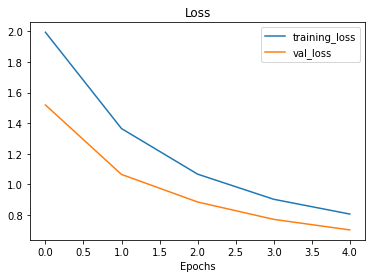

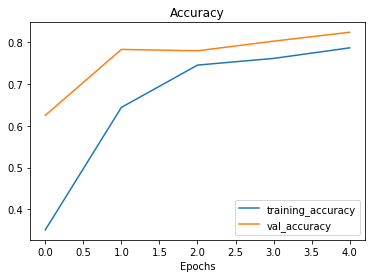

In [ ]:
plot_loss_curves(history_10percent_mod_2)

In [ ]:
model_2.load_weights(checkpoint_path)
loaded_weight_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 11s 131ms/step - loss: 0.6970 - accuracy: 0.8128


In [ ]:
results_10_percent_data_aug == loaded_weight_model_results

True

In [ ]:
import numpy as np
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weight_model_results))

array([ True,  True])

In [ ]:
print(np.array(results_10_percent_data_aug) - np.array(loaded_weight_model_results))

[0. 0.]


In [ ]:
model_2.layers

In [ ]:
for layer in model_2.layers:
  print(layer.trainable)

True
True
False
True
True


In [ ]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 augmentation_layer (Sequent  (None, None, None, 3)    0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 Global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [ ]:
print(len(model_2.layers[2].trainable_variables))

0


In [ ]:
for layer_number, layer in enumerate(base_model.layers):
  print(f'{layer_number:>4}: {layer.trainable} - {layer.name}')

   0: False - input_7
   1: False - rescaling_6
   2: False - normalization_6
   3: False - stem_conv_pad
   4: False - stem_conv
   5: False - stem_bn
   6: False - stem_activation
   7: False - block1a_dwconv
   8: False - block1a_bn
   9: False - block1a_activation
  10: False - block1a_se_squeeze
  11: False - block1a_se_reshape
  12: False - block1a_se_reduce
  13: False - block1a_se_expand
  14: False - block1a_se_excite
  15: False - block1a_project_conv
  16: False - block1a_project_bn
  17: False - block2a_expand_conv
  18: False - block2a_expand_bn
  19: False - block2a_expand_activation
  20: False - block2a_dwconv_pad
  21: False - block2a_dwconv
  22: False - block2a_bn
  23: False - block2a_activation
  24: False - block2a_se_squeeze
  25: False - block2a_se_reshape
  26: False - block2a_se_reduce
  27: False - block2a_se_expand
  28: False - block2a_se_excite
  29: False - block2a_project_conv
  30: False - block2a_project_bn
  31: False - block2b_expand_conv
  32: False

# Model 3 - Fine tuning an existing model on 10% the data

In [ ]:
base_model.trainable = True

# freeze all layers except for the top 10 layers
for number,layers in enumerate(base_model.layers[:-10]):
  layers.trainable = False
  print(number,layer, layer.trainable)

# # Recompile the model (always recompile after any adjustments to a model)
model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # lr is 10x lower than before for fine-tuning
              metrics=["accuracy"])

0 <keras.layers.core.activation.Activation object at 0x7fb139fcf110> True
1 <keras.layers.core.activation.Activation object at 0x7fb139fcf110> True
2 <keras.layers.core.activation.Activation object at 0x7fb139fcf110> True
3 <keras.layers.core.activation.Activation object at 0x7fb139fcf110> True
4 <keras.layers.core.activation.Activation object at 0x7fb139fcf110> True
5 <keras.layers.core.activation.Activation object at 0x7fb139fcf110> True
6 <keras.layers.core.activation.Activation object at 0x7fb139fcf110> True
7 <keras.layers.core.activation.Activation object at 0x7fb139fcf110> True
8 <keras.layers.core.activation.Activation object at 0x7fb139fcf110> True
9 <keras.layers.core.activation.Activation object at 0x7fb139fcf110> True
10 <keras.layers.core.activation.Activation object at 0x7fb139fcf110> True
11 <keras.layers.core.activation.Activation object at 0x7fb139fcf110> True
12 <keras.layers.core.activation.Activation object at 0x7fb139fcf110> True
13 <keras.layers.core.activation.Ac

In [ ]:
for layer_number, layer in enumerate(base_model.layers):
  print(f'{layer_number:>4} : {layer.trainable} - {layer.name}')

   0 : False - input_7
   1 : False - rescaling_6
   2 : False - normalization_6
   3 : False - stem_conv_pad
   4 : False - stem_conv
   5 : False - stem_bn
   6 : False - stem_activation
   7 : False - block1a_dwconv
   8 : False - block1a_bn
   9 : False - block1a_activation
  10 : False - block1a_se_squeeze
  11 : False - block1a_se_reshape
  12 : False - block1a_se_reduce
  13 : False - block1a_se_expand
  14 : False - block1a_se_excite
  15 : False - block1a_project_conv
  16 : False - block1a_project_bn
  17 : False - block2a_expand_conv
  18 : False - block2a_expand_bn
  19 : False - block2a_expand_activation
  20 : False - block2a_dwconv_pad
  21 : False - block2a_dwconv
  22 : False - block2a_bn
  23 : False - block2a_activation
  24 : False - block2a_se_squeeze
  25 : False - block2a_se_reshape
  26 : False - block2a_se_reduce
  27 : False - block2a_se_expand
  28 : False - block2a_se_excite
  29 : False - block2a_project_conv
  30 : False - block2a_project_bn
  31 : False -

In [ ]:
print(len(model_2.trainable_variables))

12


In [ ]:
for layer in model_2.layers:
  print(layer.name,layer.trainable)

input_layer True
augmentation_layer True
efficientnetb0 True
Global_average_pooling True
output_layer True


In [ ]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epoch + 5

# refit the model (same as model_2 except with more trainable layers)
history_fine_tune_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               initial_epoch=history_10percent_mod_2.epoch[-1], # start from previous last epoch
                                               validation_steps=int(0.25 * len(test_data)),
                                               callbacks=[create_tensorboard_callback("transfer_learning",
                                                                                      "10_percent_fine_tune_last_10")]) # name experiment appropriately

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20211217-174417


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 5/10
24/24 [==============================] - 44s 901ms/step - loss: 0.6956 - accuracy: 0.8147 - val_loss: 0.5658 - val_accuracy: 0.8076
Epoch 6/10
24/24 [==============================] - 16s 608ms/step - loss: 0.5536 - accuracy: 0.8280 - val_loss: 0.5102 - val_accuracy: 0.8191
Epoch 7/10
24/24 [==============================] - 17s 698ms/step - loss: 0.4841 - accuracy: 0.8547 - val_loss: 0.4661 - val_accuracy: 0.8339
Epoch 8/10
24/24 [==============================] - 15s 626ms/step - loss: 0.4342 - accuracy: 0.8707 - val_loss: 0.5187 - val_accuracy: 0.8372
Epoch 9/10
24/24 [==============================] - 14s 574ms/step - loss: 0.3943 - accuracy: 0.8960 - val_loss: 0.4885 - val_accuracy: 0.8438
Epoch 10/10
24/24 [==============================] - 12s 467ms/step - loss: 0.3673 - accuracy: 0.8853 - val_loss: 0.4886 - val_accuracy: 0.8388


In [ ]:
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 12s 144ms/step - loss: 0.4837 - accuracy: 0.8440


In [ ]:
results_fine_tune_10_percent

[0.4837403893470764, 0.843999981880188]

In [ ]:
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

5
11
[0.35066667199134827, 0.6439999938011169, 0.7453333139419556, 0.7613333463668823, 0.7866666913032532, 0.8146666884422302, 0.828000009059906, 0.8546666502952576, 0.8706666827201843, 0.8960000276565552, 0.8853333592414856]


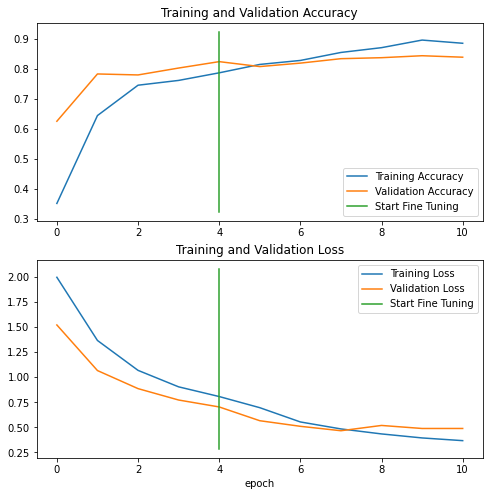

In [ ]:
compare_historys(original_history=history_10percent_mod_2, 
                 new_history=history_fine_tune_10_percent_data_aug, 
                 initial_epochs=5)

In [ ]:
# Download and unzip 10 classes of data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip 
unzip_data("10_food_classes_all_data.zip")

# Setup data directories
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

--2021-12-17 17:54:34--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.114.128, 108.177.111.128, 142.250.1.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.114.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  98.5MB/s    in 5.0s    

2021-12-17 17:54:39 (98.7 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [ ]:
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/test'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/steak'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ice_cream'.
There are 

In [ ]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                 label_mode="categorical",
                                                                                 image_size=IMG_SIZE)

# Note: this is the same test dataset we've been using for the previous modelling experiments
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
# Evaluate model (this is the fine-tuned 10 percent of data version)
model_2.evaluate(test_data)

79/79 [==============================] - 12s 140ms/step - loss: 0.4837 - accuracy: 0.8440


[0.4837403893470764, 0.843999981880188]

In [ ]:
results_fine_tune_10_percent

[0.4837403893470764, 0.843999981880188]

In [ ]:
# Load model from checkpoint, that way we can fine-tune from the same stage the 10 percent data model was fine-tuned from
model_2.load_weights(checkpoint_path) # revert model back to saved weights

In [ ]:
# After loading the weights, this should have gone down (no fine-tuning)
model_2.evaluate(test_data)

79/79 [==============================] - 12s 144ms/step - loss: 0.6970 - accuracy: 0.8128


[0.6969903111457825, 0.8127999901771545]

In [ ]:
# Check which layers are tuneable in the whole model
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 augmentation_layer True
2 efficientnetb0 True
3 Global_average_pooling True
4 output_layer True


In [ ]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_7 False
1 rescaling_6 False
2 normalization_6 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [ ]:
# Compile
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(lr=0.0001), # divide learning rate by 10 for fine-tuning
                metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# Continue to train and fine-tune the model to our data
fine_tune_epochs = initial_epoch + 5

history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs=fine_tune_epochs,
                                           initial_epoch=history_10percent_mod_2.epoch[-1],
                                           validation_data=test_data,
                                           validation_steps=int(0.25 * len(test_data)),
                                           callbacks=[create_tensorboard_callback("transfer_learning", 
                                                                                  "full_10_classes_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20211217-175834


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 5/10
235/235 [==============================] - 105s 377ms/step - loss: 0.7178 - accuracy: 0.7663 - val_loss: 0.4104 - val_accuracy: 0.8651
Epoch 6/10
235/235 [==============================] - 75s 318ms/step - loss: 0.5856 - accuracy: 0.8117 - val_loss: 0.3215 - val_accuracy: 0.8914
Epoch 7/10
235/235 [==============================] - 69s 289ms/step - loss: 0.5155 - accuracy: 0.8331 - val_loss: 0.3108 - val_accuracy: 0.9013
Epoch 8/10
235/235 [==============================] - 62s 262ms/step - loss: 0.4705 - accuracy: 0.8439 - val_loss: 0.3473 - val_accuracy: 0.8849
Epoch 9/10
235/235 [==============================] - 63s 267ms/step - loss: 0.4444 - accuracy: 0.8609 - val_loss: 0.3116 - val_accuracy: 0.8980
Epoch 10/10
235/235 [==============================] - 69s 289ms/step - loss: 0.4068 - accuracy: 0.8677 - val_loss: 0.3193 - val_accuracy: 0.8914


In [ ]:
results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data

79/79 [==============================] - 11s 131ms/step - loss: 0.3105 - accuracy: 0.8968


[0.3104637861251831, 0.8967999815940857]

5
11
[0.35066667199134827, 0.6439999938011169, 0.7453333139419556, 0.7613333463668823, 0.7866666913032532, 0.7662666440010071, 0.8117333054542542, 0.8330666422843933, 0.8438666462898254, 0.8609333038330078, 0.867733359336853]


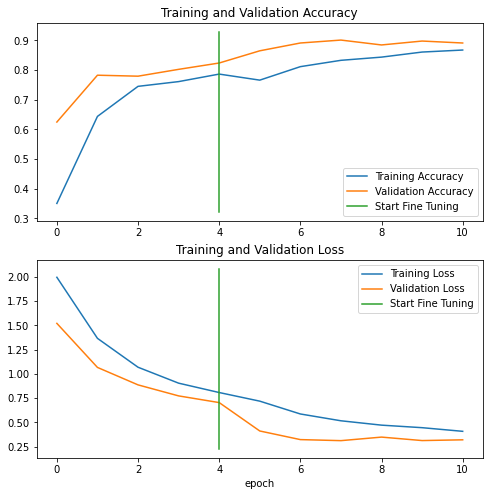

In [ ]:
# How did fine-tuning go with more data?
compare_historys(original_history=history_10percent_mod_2,
                 new_history=history_fine_10_classes_full,
                 initial_epochs=5)

In [ ]:
# View tensorboard logs of transfer learning modelling experiments (should be 4 models)
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./transfer_learning \
  --name "Transfer learning experiments" \
  --description "A series of different transfer learning experiments with varying amounts of data and fine-tuning" \
  --one_shot # exits the uploader when upload has finished


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./transfer_learning

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=g3HW3lsbgSpxFuLka2slmFnhf6tNvv&prompt=consent&access_type=o

In [ ]:
# View previous experiments
!tensorboard dev list

https://tensorboard.dev/experiment/EzVADfVWQOKpGoMymZPxkg/
	Name                 Transfer learning experiments
	Description          A series of different transfer learning experiments with varying amounts of data and fine-tuning
	Id                   EzVADfVWQOKpGoMymZPxkg
	Created              2021-12-17 18:09:52 (1 minute ago)
	Updated              2021-12-17 18:09:58 (1 minute ago)
	Runs                 12
	Tags                 5
	Scalars              168
	Tensor bytes         0
	Binary object bytes  5359923
Total: 1 experiment(s)


In [ ]:
# Remove previous experiments
# !tensorboard dev delete --experiment_id EzVADfVWQOKpGoMymZPxkg